In [1]:
import pygeostat as gs
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
gs.Parameters['plotting.sigfigs'] = 2
gs.Parameters['plotting.scatter_plot.stat_xy'] = (0.9,0.95)
gs.Parameters['plotting.scatter_plot.s'] = 2
gs.PlotStyle['figure.figsize'] = (10, 10)

<h1 style='color:#1B127A;'>
Data Generation
</h1>

In [68]:
n_sample = 100000
mean = np.array([0, 0, 0, 0])
cov = np.array([[1, 0.8, -0.6, 0.4], [0.8, 1, -0.5, 0.6], [-0.6, -0.5, 1, -0.4], [0.4, 0.6, -0.4, 1]])  # diagonal covariance
cov_inv = np.linalg.inv(cov)
n_mv_samples = np.random.multivariate_normal(mean, cov, n_sample).T

data=pd.DataFrame(dtype=np.float32)
variables = []
for i, variable in enumerate(n_mv_samples):
    var_name = 'Variable%i'%(i+1)
    variables.append(var_name)
    data[var_name] = variable

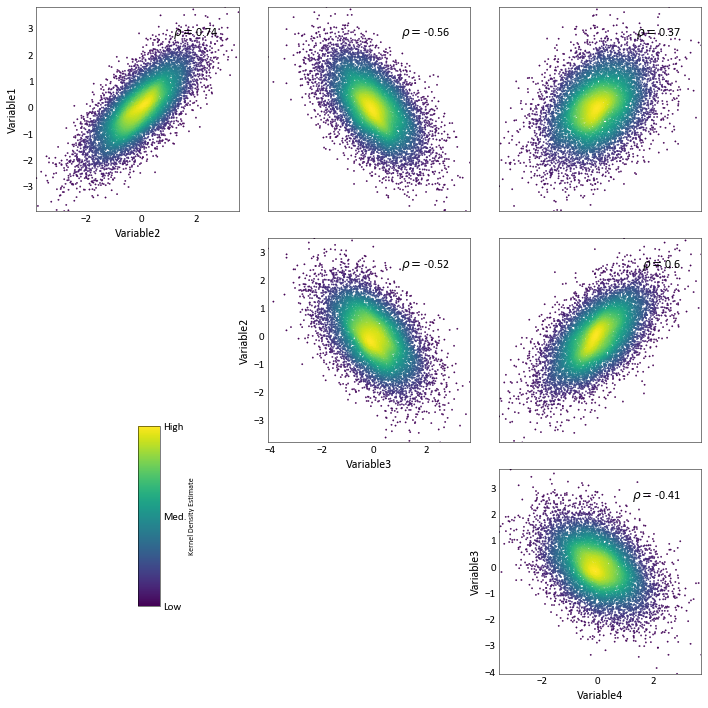

In [69]:
fig= gs.scatter_plots(data)

<h1 style='color:#1B127A;'>
Simple krigining or normal equations or linear regression
</h1>

Simple kriging is equivalent to solving multiple linear regression for each data configuration (i.e. for each missing data location). In both cases, a linear model is proposed to estimate a missing variable. The weights and bias/shift are calculated to minimize the expected squared error (i.e. error variance). It can be shown that weights of a linear model that minimizes the squared error are calculated using the covariance between conditioning variables (features) and between conditioning variables and the response variable (i.e. label).

The main difference is that in case of linear regression, the equally sampled observations of multiple variables are available and can be used to calculate the covariances and intern the wights and bias. However, in kriging (spatial interpolation), the spatial arrangement and the euclidean distance between data locations is provided. In this context, the covariance is the auto-covariance as it is the covariance between one variables and the spatially lagged bversion of the same variable (or another variable). Each data location is regarded a a random variable and the covariance is provided by a variogram model that is a statistical measure of variability as a function of Euclidean distance.

In geostatistics, experimental variograms are calculated and assumed to be representative of a stationary domain. A linear model of regionalization/co-regionalization can be used to model the variobaility/variogram along all directions. The variogram is a model of spatial variability and can be used to derive the covariance as a function of spatial distance.


The example in this notebook is used to show how simple krigining can be used to provide a linear estimator using a multivariate Gaussian data set. The main feature of a multivariate Gaussian distribution is that it is fully quantified by a covariance matrix and a mean vector and the conditional means are given by normal equations. The main objective is to evaluate the simple kriging estimator variance and show how it is expected to be lower than the response variable variance.

<h2 style='color:#5177F9;'>
Simple kriging equation
</h2>

Simple kriging is known as best linear unbiased estimate (blue). 

$z^*(u_0) = \sum \lambda_{\alpha} z(u_{\alpha}) + \lambda_0 \;\;\;\; \alpha = 1, ..., n$

Note that the random $z^*(u_0)$ is an estimate and correspondingly, the linear combination random variables $Z(u_{\alpha})$ is its self a random variable called estimator:

$Z^*(u_0) = \sum \lambda_{\alpha} Z(u_{\alpha}) + \lambda_0 \;\;\;\; \alpha = 1, ..., n$

where $u$ denotes the location of a random variable in the spatial coordinate system. While the actual error $z(u_0)-z^*(u_0)$ is usually unknown, the expected values of the error random variable i.e. $Z(u_0)-Z^*(u_0)$ can be calculated.

$E\{Z(u_0)-Z^*(u_0)\} = E\{Z(u_0)\} - E\{Z^*(u_0\} = m_0 - \lambda_0 - \sum \lambda_{\alpha}m_{\alpha}$

In order to have an unbiased estimator, we want the expected error to be zero

$E\{Z(u_0)-Z^*(u_0)\} = 0 \rightarrow  \;\; \lambda_0 = m_0 - \sum \lambda_{\alpha} m_{\alpha}$

Thus the linear estimator can be written as:

$Z^*(u_0)- m_0= \sum \lambda_{\alpha} (Z(u_{\alpha}) - m_{\alpha})  \;\;\;\; \alpha = 1, ..., n$

In order to solve Simple kriging, either the mean is constant and known everywhere (i.e. first order stationarity) or the mean is know at each data location (e.g. a trend model informed by local averaging or secondary data).

The weights are then found based on minimizing the error variance i.e. $E\{(Z_0-Z^*_0)^2\}$. 


$\sum_{\beta=1}^{n} \lambda_{\beta} Cov(u_{\alpha}-u_{\beta}) =  Cov(u_{\alpha}-u_{0})\;\;\;\; \alpha = 1, ..., n$

Note that knowing the mean is necessary for the theoretical derivation that results in using the covariance function that is informed by the variogram model. 

In [79]:
conditioning_vars = data.columns[:-1]
response_var = data.columns[-1]

print('Conditining variables (features):', ', '.join(conditioning_vars))
print('Response variable (label):', ', '.join([response_var]))

Conditining variables (features): Variable1, Variable2, Variable3
Response variable (label): Variable4


In [80]:
# With the assumption of estimating conditional moments for the last variable
K = cov[:-1,:-1] # Cij
k = cov[-1,:-1].reshape(K.shape[0],1)
C00= cov[-1,-1]
Z_mean = mean[:-1].reshape(K.shape[0],1)
Z0_mean = mean[0]
lambdas = np.matmul(k.T, np.linalg.inv(K)) # trasnpose of lamdas
print('Conditining weight are:{}'.format(*lambdas))
print('Note that the conditining weights only depend on covriances and not the conditioning values')

Conditining weight are:[-0.21052632  0.67368421 -0.18947368]
Note that the conditining weights only depend on covriances and not the conditioning values


In [72]:
def conditional_mean(Z):
    Z = np.array(Z).reshape(len(Z),1)
    result = np.matmul(lambdas, (Z-Z_mean)) + Z0_mean
    return result.flatten()[0]

def conditional_variance():
    result = C00 - np.matmul(lambdas,k)
    return result.flatten()[0]

conditional_variance()

0.6042105263157894

In [73]:
estimate = data[data.columns[:-1]].apply(lambda x: conditional_mean(x), axis=1)

In [74]:
np.var(estimate)

0.401011379779114

In [75]:
C00 - np.var(estimate)

0.5989886202208861

In [76]:
conditional_variance()

0.6042105263157894

In [77]:
X = data.values[:,0:-1]
y = data.values[:,-1]

In [78]:
np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T,X)), X.T),y)

array([-0.20977658,  0.67738802, -0.18649843])